<a href="https://colab.research.google.com/github/easyhardhoon/machine_learning/blob/master/ML17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#코드 복습

사실 아래 코드는 지금까지의 모든 이론이 담겨 있는 코드입니다

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import pickle
import numpy as np
from collections import OrderedDict
from layers import *
from gradient import numerical_gradient


class SimpleConvNet:
    """단순한 합성곱 신경망
    
    conv - relu - pool - affine - relu - affine - softmax
    
    Parameters
    ----------
    input_size : 입력 크기（MNIST의 경우엔 784）
    hidden_size_list : 각 은닉층의 뉴런 수를 담은 리스트（e.g. [100, 100, 100]）
    output_size : 출력 크기（MNIST의 경우엔 10）
    activation : 활성화 함수 - 'relu' 혹은 'sigmoid'
    weight_init_std : 가중치의 표준편차 지정（e.g. 0.01）
        'relu'나 'he'로 지정하면 'He 초깃값'으로 설정
        'sigmoid'나 'xavier'로 지정하면 'Xavier 초깃값'으로 설정
    """
    def __init__(self, input_dim=(1, 28, 28), 
                 conv_param={'filter_num':30, 'filter_size':5, 'pad':0, 'stride':1},
                 hidden_size=100, output_size=10, weight_init_std=0.01):
        filter_num = conv_param['filter_num']
        filter_size = conv_param['filter_size']
        filter_pad = conv_param['pad']
        filter_stride = conv_param['stride']
        input_size = input_dim[1]
        conv_output_size = (input_size - filter_size + 2*filter_pad) / filter_stride + 1
        pool_output_size = int(filter_num * (conv_output_size/2) * (conv_output_size/2))

        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(filter_num, input_dim[0], filter_size, filter_size)
        self.params['b1'] = np.zeros(filter_num)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(pool_output_size, hidden_size)
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Conv1'] = Convolution(self.params['W1'], self.params['b1'],
                                           conv_param['stride'], conv_param['pad'])
        self.layers['Relu1'] = Relu()
        self.layers['Pool1'] = Pooling(pool_h=2, pool_w=2, stride=2)
        self.layers['Affine1'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W3'], self.params['b3'])

        self.last_layer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """손실 함수를 구한다.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블
        """
        y = self.predict(x)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        acc = 0.0
        
        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt) 
        
        return acc / x.shape[0]

    def numerical_gradient(self, x, t):
        """기울기를 구한다（수치미분）.

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        loss_w = lambda w: self.loss(x, t)

        grads = {}
        for idx in (1, 2, 3):
            grads['W' + str(idx)] = numerical_gradient(loss_w, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_w, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """기울기를 구한다(오차역전파법).

        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블

        Returns
        -------
        각 층의 기울기를 담은 사전(dictionary) 변수
            grads['W1']、grads['W2']、... 각 층의 가중치
            grads['b1']、grads['b2']、... 각 층의 편향
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Conv1'].dW, self.layers['Conv1'].db
        grads['W2'], grads['b2'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W3'], grads['b3'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads
        
    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, key in enumerate(['Conv1', 'Affine1', 'Affine2']):
            self.layers[key].W = self.params['W' + str(i+1)]
            self.layers[key].b = self.params['b' + str(i+1)]

#딥러닝

딥러닝은, **층을 깊게 한 심층 신경망**이다.

그럼, 지금까지의 신경망(예컨데 simpleConvNet)을 바탕으로 뒷단에 층을 추가하기만 하면 되지 않을까??


Mounted at /gdrive


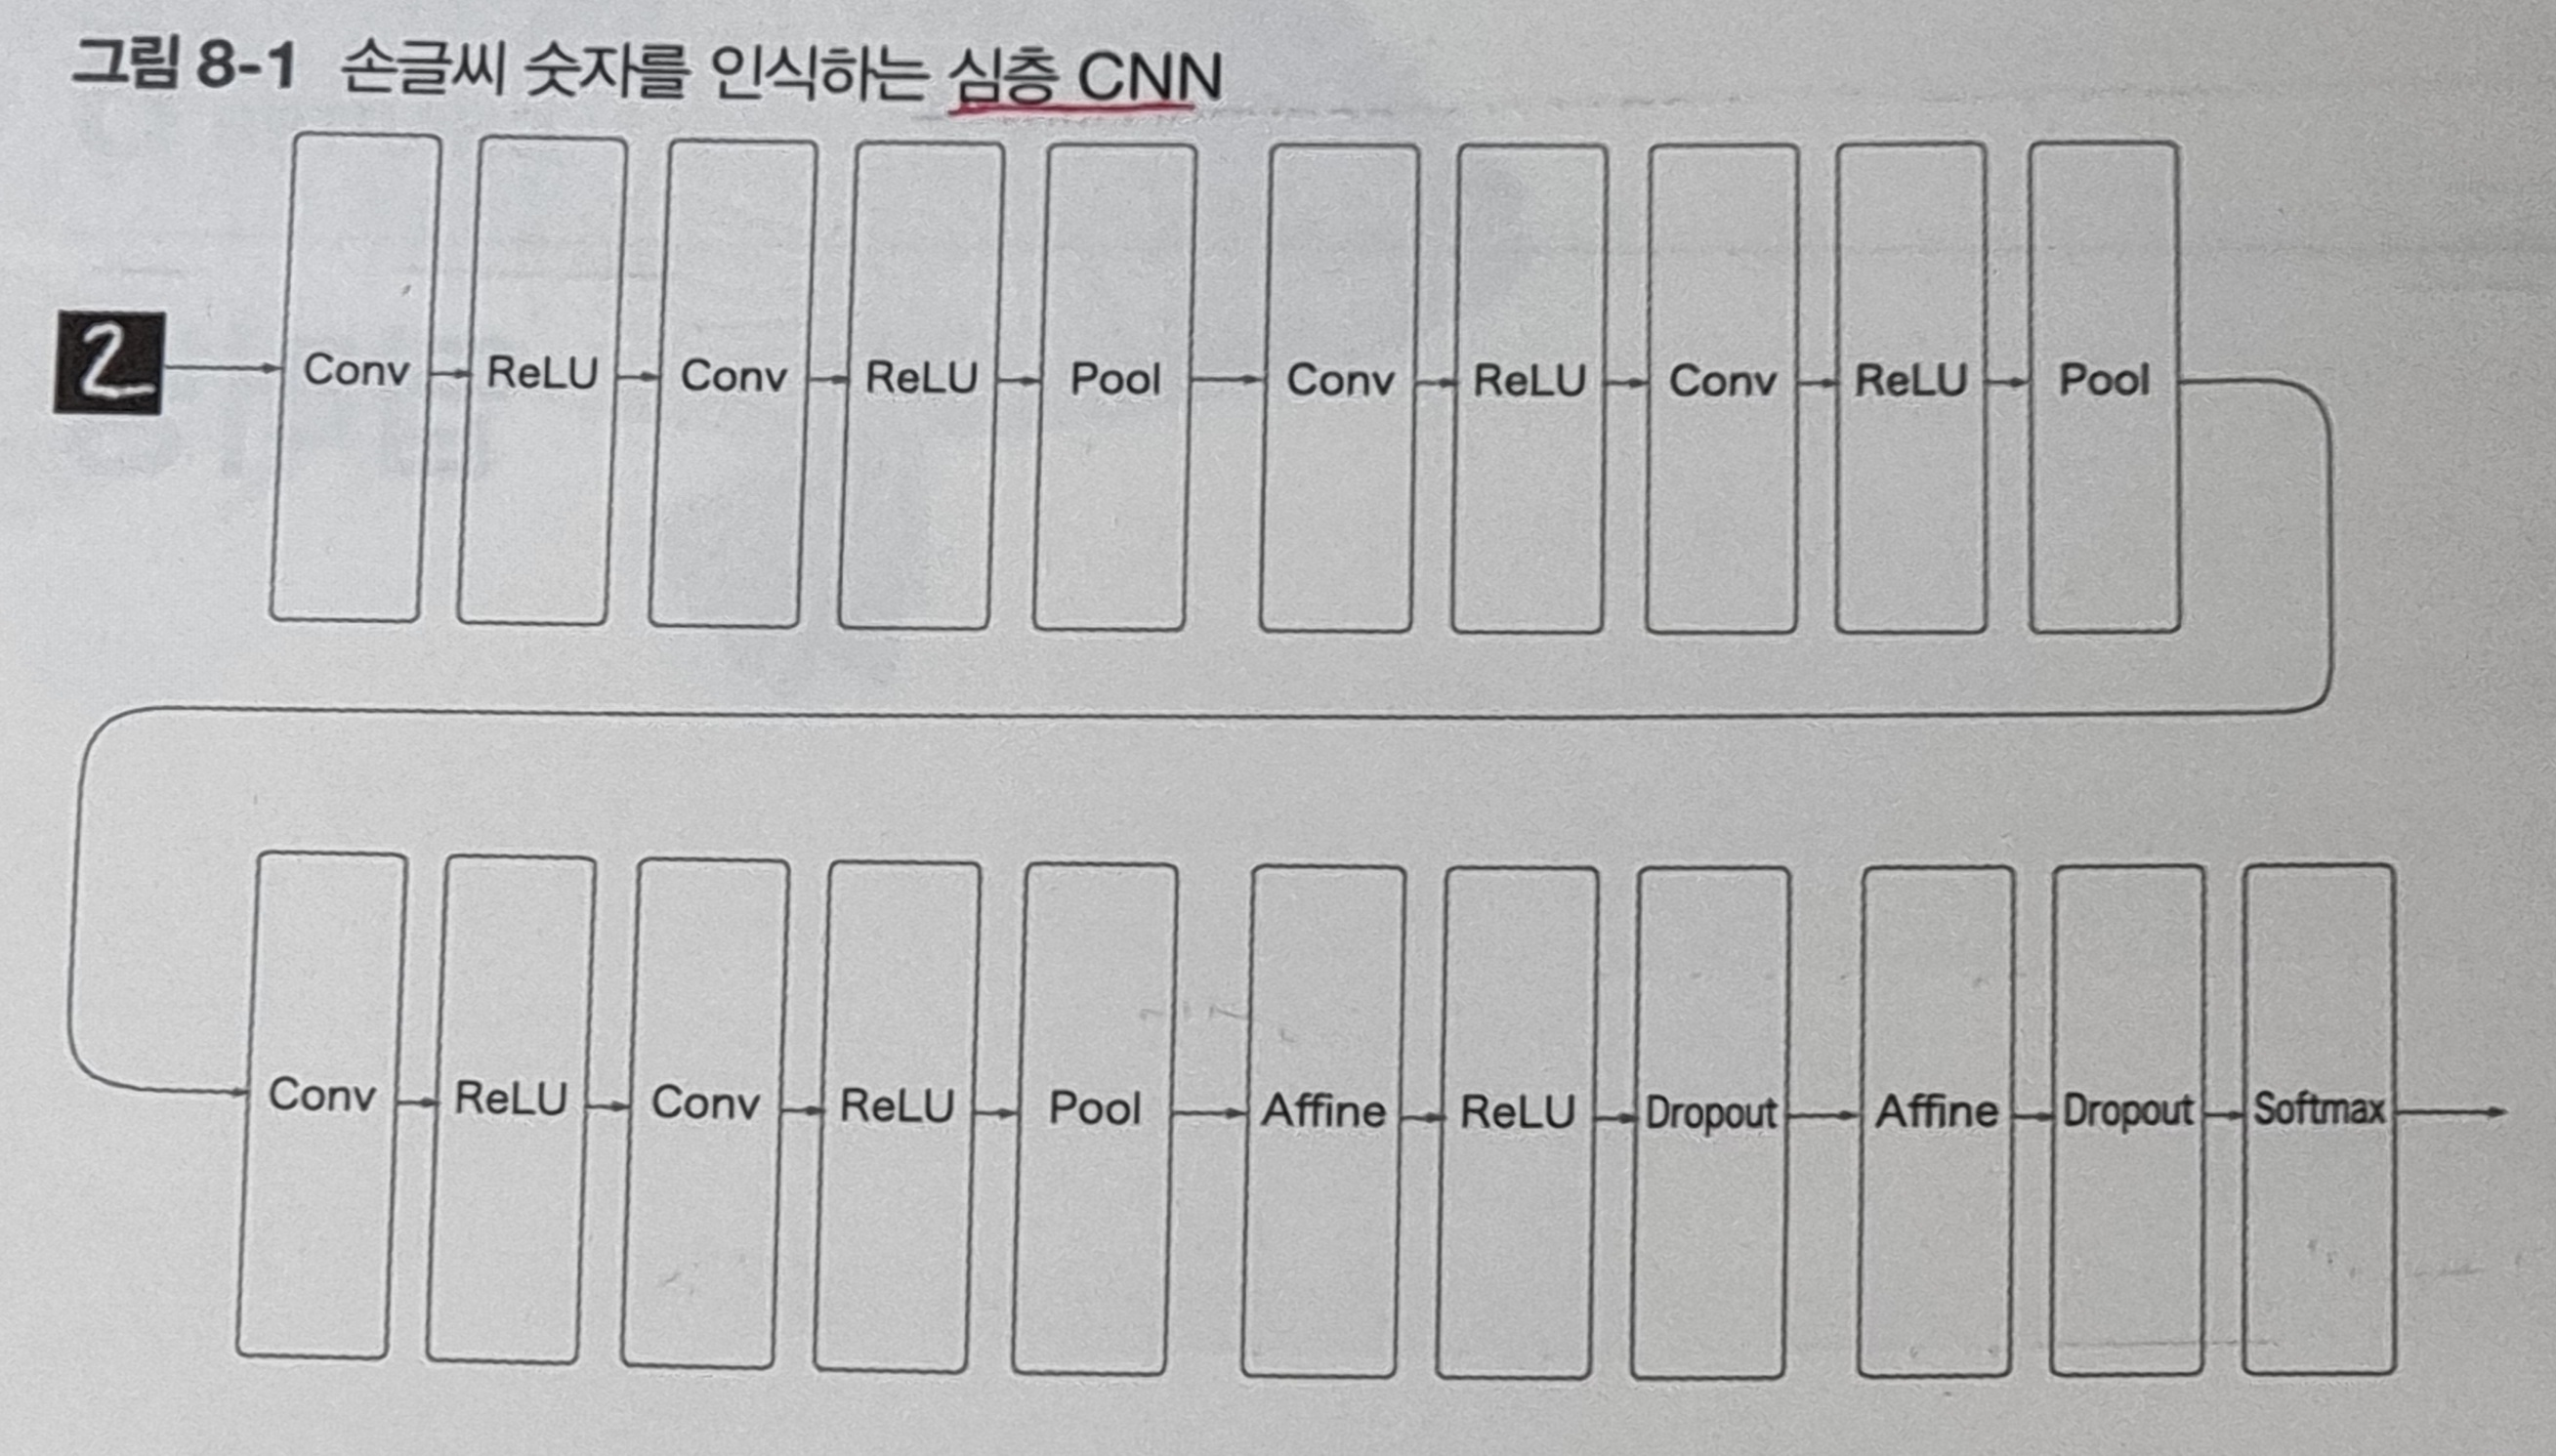

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)
from IPython.display import Image
Image('/gdrive/My Drive/ex4.jpg')

#우리는 이제 위와 같은 심층 CNN을 만들고자 한다. (VGG 신경망을 참고하였습니다)

⏰간단한 복습

✈가중치의 초깃값 설정법 : 0.01(from 정규분포), Xavier 초깃값, He초깃값(RELU전용)

✈가중치의 초깃값 설정안하는 고급 기술 : 배치 정규화

✈오버피팅 방지법 : 가중치 감소, 드롭아웃

✈가중치 매개변수 갱신법 : SGD, 모멘텀, AdaGrad, Adam

**위의 심층 CNN은**

->3^3 의 작은 필터를 사용한 합성곱 계층( 층이 깊어질수록 채널 수가 증가합니다)

(합성곱 계층의 채널 수와 필터의 채널 수는 같아야함이 일반적입니다)

->RELU 활성화 함수, 가중치 초깃값은 RELU전용 초깃값인 HE초깃값 사용

->완전연결 계층(Affine) 뒤의 드롭아웃 계층

->Adam을 이용해 가중치 매개변수 갱신 최적화

->pooling 계층을 이용해 중간 데이터의 공간 크기를 점차 줄여나감


In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 부모 디렉터리의 파일을 가져올 수 있도록 설정
import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from deep_convnet import DeepConvNet
from trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(flatten=False)

network = DeepConvNet()  
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=20, mini_batch_size=100,
                  optimizer='Adam', optimizer_param={'lr':0.001},
                  evaluate_sample_num_per_epoch=1000)
#network.load_params("deep_convnet_params.pkl") #너무 오래 걸리니 이미 학습된 매개변수를 가져옵니다
trainer.train()

# 매개변수 보관
network.save_params("deep_convnet_params.pkl")
print("Saved Network Parameters!")

Saved Network Parameters!


#이렇게

심층 신경망의 학습 코드를 작성 할 수 있다. 

실제 코드를 돌려보면 반나절은 족히 걸린다. 

실제 정확도를 구해보면, 99.38 %로, 이전의 단순신경망(98%)보다 상승한 모습을 알 수 있다

그럼 0.62%는 무엇인가?? 실제 인식하지 못한 MNIST이미지를 보면, 나조차도 판단하기 어려운 이미지들이다. (ex 0,6)

즉, 심층 CNN은 정확도가 높고, 잘못 인식한 이미지들도 인간과 비슷한 인식 오류를 저지르기 때문에, **잠재력이 크다**는 것을 알 수 있다.

# 다양한 딥러닝 모델들의 경쟁(contest)

https://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html

<MNIST> 데이터셋에 대한 각 기법의 순위를 보면,

CNN을 기초로 한 기법들이 점령했음을 알 수 있다.

놀랍게도, 1등을 한 기법은 합성곱 계층 2개, 완전연결 계층 2개 정도의 단순한 신경망이다. 

(MNIST 데이터셋은, 비교적 단순한 문제라 층을 아주 깊게 하여 신경망의 표현력을 극한까지 높일 필요가 없다.)

상위 기법들을 살펴보면, 정확도를 끌어올리는 skill들을 발견할 수 있다.

앙상블 학습(드롭아웃), 학습률 감소, 데이터 확장 등이다.






✈**데이터 확장** : 입력 이미지를 알고리즘을 동원해 인위적으로 확장.

    입력 이미지 회전, 세로 이동, 잘라내기, 좌우뒤집기 등으로 미세한 변화를 주어 

    이미지(훈련 데이터)의 개수를 늘린다. 트릭이라 볼 수 있지만, 아주 효과적이다 

#층을 깊게 하는 이유

층의 깊이에 비례해 정확도가 높아진다고 알려져 있다

✈**이점 1 : 신경망의 매개변수 수가 줄어든다**

5^5 합성곱 연산 1회는 3^3 합성곱 연산 2회 수행하여 대채할 수 있다.

이는, 매개변수가 25개에서 18개로 줄어든다는 의미이다(-7)

이러한 현상은 층이 깊어질수록 커진다

예컨데, 7^7 합성곱 연산 1회는 3^3 합성곱 연산 3회 수행하여 대채할 수 있다.

이는, 매개변수가 49개에서 27개로 줄어든다는 의미이다(-22)

**즉, 더 적은 매개변수를 들여 수용 영역이 넓어지고, 더 많은 활성화 함수를 이용하여 신경망의 표현력이 개선된다.**

✈**이점 2 : 학습의 효율성이 커진다**

층을 깊게 함으로써 학습 데이터의 양을 줄여 학습을 고속으로 수행할 수 있다.

ex) CNN 시각화 : "개"의 인식

얇은 신경망에서 문제를 해결하려면 합성곱 계층은 개의 특징 대부분을 한번에 이해해야 한다. 그래서 수많은 학습 데이터가 필요하고 학습 시간이 오래걸린다.

하지만 깊은 신경망에서는 학습해야 할 문제를 계층적으로 분해,전달할 수 있다.

(처음에는 에지등의 단순한 패턴에서 점차 텍스쳐,전체 이미지 등등으로...)

즉, 각 층이 학습해야 할 문제를 더 단순한 문제로 대체할 수 있다.

**다시말하면 층을 깊게 함으로써 각 층이 학습해야 할 문제를 "풀기 쉬운 단순한 문제"들로 분해할 수 있어서, 효율적인 학습이 가능하다**

하지만!! 이 모든것의 근간은 빅데이터와 GPU기술의 발전이라는 것을 잊어서는 안된다.

#딥러닝의 초기 역사

이미지 인식 기술 대회인 ILSVRC에서, 2012년 발표된 AlexNet(8층)이 딥러닝의 등장이었다.

이후 딥러닝을 활용한 기법이 발전되어왔고 2015년에는 150층이 넘는 심층 신경망인

ResNet이 오류율을 3.5%까지 낮추었고 이는 인간의 인식 능력을 넘어섰다.

이들 중 유명하고 흔히 쓰이는 신경망을 3가지 소개한다.

⚾VGG 

    합성곱 계층과 풀링 계층으로 구성되는 기본적인 CNN이다. 

    3^3 의 작은 필터를 사용한 합성곱 계층(&풀링)을 **연속으로** 거친다.

    구성이 간단하여 응용하기 좋고 범용성이 좋다. (후의 모델의 기반이 됌)

⚾GoogLeNet

    구성이 복잡하다. 

    세로 방향 깊이뿐이 아니라 가로 방향도 깊다. 즉, 가로 방향에 폭이 있다. 이러한 구조를 **인셉션 구조**라고 한다

    인셉션 구조 : 크기가 다른 필터(ex 1^1, 3^3, 5^5 ...)를 여러개 적용하여 그 결과를 결합한다. 

⚾ResNet(가장 최근에 1등)

    스킵 연결을 도입하여 층을 너무 깊게 하면 학습이 잘 되지 않고 성능이 떨어지는 문제를 해결함

    층의 깊이에 비례해 성능을 향상시키는 아이디어. 실제로 150층 이상으로 해도 정확도가 계속 오름.

    스킵 연결 : 입력 x를 연속한 두 합성곱 계층을 건너뛰어 바로 연결. 일종의 안전장치. ( ex. 활성화함수 직전 값이 f(x) -> f(x) + x )

    이로 인해 층이 깊어짐에 따른 역전파 때 신호 감쇠(기울기 손실 문제)를 줄여주게 된다


✅참고 : 딥러닝 학습 때, 보유한 학습데이터셋이 부족할때 전이 학습을 통해 문제 해결이 가능하다. 

✅전이 학습 : 학습된 가중치를 다른 신경망에 복사한 다음 그 상태로 재학습을 수행

#딥러닝 고속화

딥러닝에서 대량의 연산을 위해, GPU를 사용하고 있다.

최근에는 극대량의 연산이 필요해서, 요즘 프레임워크에서는 학습을 복수의 GPU와 여러 기기로 **분산 수행**을 한다

✅참고 : 딥러닝에서는 합성곱 계층의 연산에 전체의 90%에 달하는 시간이 소요된다.

✅즉, 어떻게 합성곱 계층의 연산을 고속으로 효율적으로 하느냐가 과제이다. 

✅사실 합성곱 계층의 연산도 행렬곱의 누적이다. 

⚾GPU의 재평가

원래 GPU는 그래픽 전용 보드(게임용)이었다. 그러나 이 GPU의 초고속 병렬 수치 연산 처리 능력을 

다양한 용도로 활용하자는 방안이 제시되었고, 이를 GPU 컴퓨팅이라고 한다.  

im2col로 인해 입력값을 큰 행렬의 곱으로 나타낼 수 있었고, 이는 GPU의 대량의 병렬 연산 능력을 극대화 할 수 있었다.

(GPU는 작은 단위로 계산하기 보다는 큰 덩어리를 한번에 계산하는데 유리하다)

(딥러닝 학습 시간 40일 -> 6일로 단축)


#그래도

뛰어난 신경망을 만들려면 수많은 학습 시행착오를 거쳐야 하는데, 한번의 연산시간에 6일이나 걸리는건 너무 비효율적이다.

그래서 등장한 것이 **분산 학습**이다.

딥러닝 계산을 더더욱 고속화하기 위해서, **다수의 GPU와 기기로 계산을 분산**한다.

많은 딥러닝 프레임워크(tensorflow,CNTK....)에서 이러한 분산 학습에 역점을 두고 개발중이다.

실제로 분산 학습을 통해 GPU를 100개까지 사용하면 성능이 56배 빨라지게 되어, 7일짜리 작업을 3시간만에 끝낼 수 있다.

#하지만

분산학습의 "어떻게 계산을 분산하느냐"의 문제는 굉장히 어렵고 복잡하다.

이 문제는 텐서플로같은 프레임워크에 구현이 되어있고 여기에 맡기는 편이 현명하다

#변수

딥러닝 고속화를 방해하는 요인에는 시간뿐만이 아니라,

메모리 용량과 버스 대역폭(상대적으로 느린 I/O bus)등이 병목이 될 수 있다.

⚾메모리 용량

    대량의 가중치 매개변수와 중간 데이터가 메모리에 저장되어야 한다

⚾버스 대역폭

    GPU의 버스를 타고 흐르는 데이터가 많아지면 병목이 일어난다.

그래서 네트워크로 주고받는 데이터의 비트수는 최소로 만드는 것이 바람직하다

컴퓨터에서는 실수 표현을 주로 64또는 32비트로 사용한다. 

다행히 딥러닝은 높은 수치 정밀도를 요구하지 않는 견고성을 가지고 있어서,

 신경망에 흐르는 데이터를 downgrade시켜도 출력에 주는 영향은 적다

그래서 요즘은 실수를 표현하는 방식을 실제의 32 or 64비트를 **16비트까지 반정밀도시켜서 사용**한다. 

여기서 더 나아가, 가중치와 중간 데이터를 1비트로 표현하는 방법도 등장했다.

이렇게 딥러닝을 고속화하기 위해 **비트를 줄이는 기술**은 앞으로도 주시해야할 분야이다.

#딥러닝의 활용

딥러닝의 기술은 지금까지의 MNIST 이미지 데이터말고도, 음성, 자연어 등 수많은 분야에서 활용된다. 

구체적으로 딥러닝이 할 수 있는 일은, 컴퓨터 비젼 분야에서

사물 검출, 분할, 사진 캡션 생성(이미지&자연어)등이 있다.

사진 캡션 생성에서 이미지 데이터와 자연어 데이터를 동시에 조합하고 처리하는 것처럼,

**여러 종류의 데이터 정보를 조합하고 처리하는 것을 멀티모달 처리**라고 한다.

⚾RNN에 대하여

    순환 신경망, 재귀 신경망이라고도 불리며, 자연어나 시계열 데이터와 같은 연속된 데이터를 다룰 때 많이 사용한다. 

    (참고로 지금까지의 이미지 데이터는 CNN을 많이 사용한다)

    RNN의 순환적인 구조로 인해 이전에 생성한 정보에 영향을 받는 점이 특징이다.

    ex) '나'라는 단어를 생성한 뒤 '잤다'라는 단어를 생성하면 먼저 만든 '나'의 영향을 받아 '는'이라는 조사가 자동으로 생성된다.

    이처럼 자연어와 시계열 데이터 등 연속성 있는 데이터를 다룰 때 RNN은 과거의 정보를 기억하면서 동작한다.

    자연어 데이터의 딥러닝때 RNN이 많이 활용된다는 점을 기억하자

    



#딥러닝의 미래

▶이미지 스타일 변환

    딥러닝을 활용하여 화가처럼 그림을 그린다. 두 이미지를 입력하여 새로운 그림을 생성한다. 
    
    ex) 일반 사진에 고흐의 화풍을 입힌다. 

▶이미지 생성

    아무런 입력 이미지 없이 새로운 이미지를 그려낸다( DCGAN ) 사실 학습할 때는 수많은 입력 이미지가 있었겠지만... 
    
    생성자와 식별자라고 불리는 신경망을 2개 만들고 이 둘을 겨루도록 학습시킨다. 생성자는 더 정교한 가짜 이미지 생성 기술을 학습하고 
    
    식별자는 더 정확하게 간파하는 감정사로 성장한다. 이렇게 둘의 능력을 갈고닦아 진짜와 착각할 정도의 이미지를 그려낸다

    ex) 아직 아무도 본 적이 없는 침실의 이미지를 생성한다. 


✅참고로

"이미지 데이터"와 "정답 레이블"을 짝지은 데이터셋(ex MNIST)을 이용하는 학습을 **지도학습**이라 하고

단지 대량의 이미지 데어터만 주어진 데이터셋(ex DCGAN)을 이용하는 학습을 **자율학습**이라고 한다


▶자율 주행

    주위 환경을 올바르게 인식하는 기술이 가장 중요한데, 여기에도 CNN 기반 신경망인 SegNet가 큰 역할을 해주고 있다.

    또한 이미지(자동차에서 본 뷰)를 분할하는데, 앞선 컴퓨터 비전의 픽셀 수준 판정법을 사용한다.

    "분할" 역시 컴퓨터 비전 분야의 딥러닝 기술입니다.

    분할이란 입력 데이터 속 이미지를 픽셀 수준으로 분류하는 것을 말합니다

    그래서 분할 기술을 통해 전방 사물들, 즉 어떤 것은 신호등이고 어떤 것은 오토바이다.

    이런 것을 판별해줍니다. 이 정보를 가지고 또 적절한 판단을 내리는 딥러닝 기술(SegNet)과 여타 기술들이 조합되어 , 자율 주행 기술이 완성됩니다

▶강화학습


    에이전트는 환경에 맞게 행동을 선택하고, 그 행동에 의해서 환경이 변한다.

    환경이 변하면 어떠한 보상을 얻는다. 더 나은 보상을 받는 쪽으로 에이전트의 행동 지침을 바로잡는다

    즉, 에이전트는 더 좋은 보상을 받기 위해 스스로 학습한다.

    여기서 보상은, 명확한 지표로부터 역산하여 정해야만 한다. 정해진 보상이 아니라 예상 보상이다.

    이러한 강화학습을, 딥러닝을 이용해 구현할 수 있다. (DQN)

    최적 행동 가치 함수를 딥러닝으로 비슷하게 흉내내는 식이다.

    DQN 연구로, 비디오 게임을 자율 학습시켜 사람을 뛰어넘는 수준의 조작을 실현하였다. 

    여기서 핵심은, DQN에게 주어지는 입력 데이터는 오직 비디오 게임의 영상뿐이라는 것이다.

    이 점으로 인해, DQN의 응용 가능성은 매우 높다



✅알파고에 대하여

알파고에도 딥러닝과 강화학습이 이용되었다. 

알파고는 3만개의 프로 기보를 **보며** 학습한 후 알파고 자신과 스스로 맞붙는 대결을 반복하며 수련하였다.


#마무리하며

이렇게 [밑바닥부터 시작하는 딥러닝 1] 의 공부를 완료하였습니다. [22.01.12~ 22.02.02] 

이에 대한 복습과 함께, [밑바닥부터 시작하는 딥러닝 2]의 공부도 지속될 예정입니다. 